In [48]:
import pandas as pd
import numpy as np

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Visualization (for inspection)
import matplotlib.pyplot as plt
import seaborn as sns


# Cleaning


In [49]:
# Load CSV file (specify encoding to avoid UnicodeDecodeError)
df = pd.read_csv("25k_IMDb_movie_Dataset.csv", engine='python', encoding='latin-1')

# Quick look
df.head()


,movie title,Run Time,Rating,User Rating,Generes,Overview,Plot Kyeword,Director,Top 5 Casts,Writer,year,path
0,Top Gun: Maverick,"$170,000,000 (estimated)",8.6,187K,"['Action', 'Drama']",After more than thirty years of service as one...,"['fighter jet', 'sequel', 'u.s. navy', 'fighte...",Joseph Kosinski,"['Jack Epps Jr.', 'Peter Craig', 'Tom Cruise',...",Jim Cash,-2022,/title/tt1745960/
1,Jurassic World Dominion,2 hours 27 minutes,6,56K,"['Action', 'Adventure', 'Sci-Fi']",Four years after the destruction of Isla Nubla...,"['dinosaur', 'jurassic park', 'tyrannosaurus r...",Colin Trevorrow,"['Colin Trevorrow', 'Derek Connolly', 'Chris P...",Emily Carmichael,-2022,/title/tt8041270/
2,Top Gun,"$15,000,000 (estimated)",6.9,380K,"['Action', 'Drama']",As students at the United States Navy's elite ...,"['pilot', 'male camaraderie', 'u.s. navy', 'gr...",Tony Scott,"['Jack Epps Jr.', 'Ehud Yonay', 'Tom Cruise', ...",Jim Cash,-1986,/title/tt0092099/
3,Lightyear,"$71,101,257",5.2,32K,"['Animation', 'Action', 'Adventure']",While spending years attempting to return home...,"['galaxy', 'spaceship', 'robot', 'rocket', 'sp...",Angus MacLane,"['Jason Headley', 'Matthew Aldrich', 'Chris Ev...",Angus MacLane,-2022,/title/tt10298810/
4,Spiderhead,not-released,5.4,23K,"['Action', 'Crime', 'Drama']","In the near future, convicts are offered the c...","['discover', 'medical', 'test', 'reality', 'fi...",Joseph Kosinski,"['Rhett Reese', 'Paul Wernick', 'Chris Hemswor...",George Saunders,-2022,/title/tt9783600/


In [50]:
print(df.shape)
df.info()


(24402, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24402 entries, 0 to 24401
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movie title   24402 non-null  object
 1   Run Time      24402 non-null  object
 2   Rating        24402 non-null  object
 3   User Rating   24402 non-null  object
 4   Generes       24402 non-null  object
 5   Overview      24158 non-null  object
 6   Plot Kyeword  24402 non-null  object
 7   Director      24402 non-null  object
 8   Top 5 Casts   24402 non-null  object
 9   Writer        24402 non-null  object
 10  year          23624 non-null  object
 11  path          24402 non-null  object
dtypes: object(12)
memory usage: 2.2+ MB


In [51]:
df.isnull().sum()

movie title       0
Run Time          0
Rating            0
User Rating       0
Generes           0
Overview        244
Plot Kyeword      0
Director          0
Top 5 Casts       0
Writer            0
year            778
path              0
dtype: int64

In [52]:
df = df.dropna(subset=["movie title", "Overview", "Top 5 Casts"])

# Remove rows where Run Time indicates 'not-released' (original code used a boolean expression by mistake)
df = df[~df["Overview"].astype(str).str.lower().str.contains("none", na=False)]

df["Overview"] = df["Overview"].astype(str)
df = df.drop_duplicates(subset=["movie title", "year"])

print("Cleaned dataset size:", df.shape)



Cleaned dataset size: (23518, 12)


In [54]:
def extract_top_cast(cast_str, n=3):
    if pd.isna(cast_str):
        return ""
    return " ".join(
        [f"actor_{actor.strip().replace(' ', '')}" 
         for actor in cast_str.split(",")[:n]]
    )

def clean_director(director):
    if pd.isna(director):
        return ""
    return f"director_{director.strip().replace(' ', '')}"



# Text Preprocessing

In [55]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text) 
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)


In [56]:
df["clean_overview"] = df["Overview"].apply(clean_text)
df["clean_genre"] = df["Generes"].apply(clean_text)
df["clean_cast"] = df["Top 5 Casts"].apply(lambda x: extract_top_cast(x, 3))
df["clean_director"] = df["Director"].apply(clean_director)



In [57]:
df["movie_profile"] = df["clean_overview"] + " " +df["Plot Kyeword"]+" "+ df["clean_genre"]+" "+ df["clean_director"]+ " " + df["clean_cast"]


df[["movie title", "movie_profile"]].head()


,movie title,movie_profile
0,Top Gun: Maverick,thirty year service one navy top aviator pete ...
1,Jurassic World Dominion,four year destruction isla nublar dinosaur liv...
2,Top Gun,student united state navy elite fighter weapon...
3,Lightyear,spending year attempting return home marooned ...
4,Spiderhead,near future convict offered chance volunteer m...


In [58]:
df = df.reset_index(drop=True)


# TF-IDF

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=20000,
    max_df=0.9,
    min_df=3,
    ngram_range=(1, 2)
)



tfidf_matrix = tfidf.fit_transform(df["movie_profile"])
print("TF-IDF matrix shape:", tfidf_matrix.shape)



TF-IDF matrix shape: (23518, 20000)


In [61]:
tfidf.get_feature_names_out()[:200]


array(['007', '10', '10 year', '11', '11 2001', '11th', '11th century',
       '12', '12 year', '12th', '12th century', '13', '13 year', '13th',
       '13th century', '14', '14 year', '14th', '14th century', '15',
       '15 year', '1500s', '15th', '15th century', '16', '16 year',
       '1600s', '16th', '16th century', '17', '17 year', '1700s', '17th',
       '17th century', '18', '1800s', '1810s', '1830s', '1840s', '1850s',
       '1860s', '1870s', '1880s', '1890s', '1890s timeframe', '18th',
       '18th century', '19', '1900s', '1910s', '1910s timeframe', '1917',
       '1918', '1919', '1920s', '1920s timeframe', '1930s',
       '1930s timeframe', '1937', '1940', '1940s', '1940s timeframe',
       '1940s world', '1941', '1942', '1943', '1944', '1944 1940s',
       '1944 year', '1945', '1950s', '1950s timeframe', '1951', '1956',
       '1959', '1960', '1960s', '1960s timeframe', '1962', '1963', '1968',
       '1969', '1970s', '1970s timeframe', '1971', '1972', '1973', '1976',
     

# PCA

In [62]:
from sklearn.decomposition import TruncatedSVD


In [63]:
n_components = 70

svd = TruncatedSVD(n_components=n_components, random_state=42)
pca_features = svd.fit_transform(tfidf_matrix)



In [64]:
explained_variance = svd.explained_variance_ratio_
print("Total explained variance:", explained_variance.sum())


Total explained variance: 0.10709522305128795


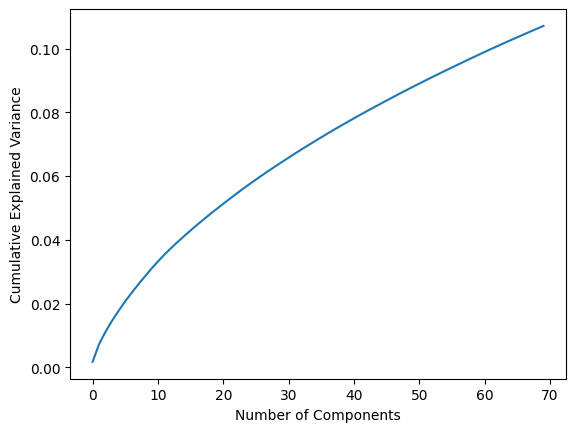

In [65]:
plt.plot(np.cumsum(explained_variance))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()


# remove outliers

In [66]:
from sklearn.cluster import DBSCAN


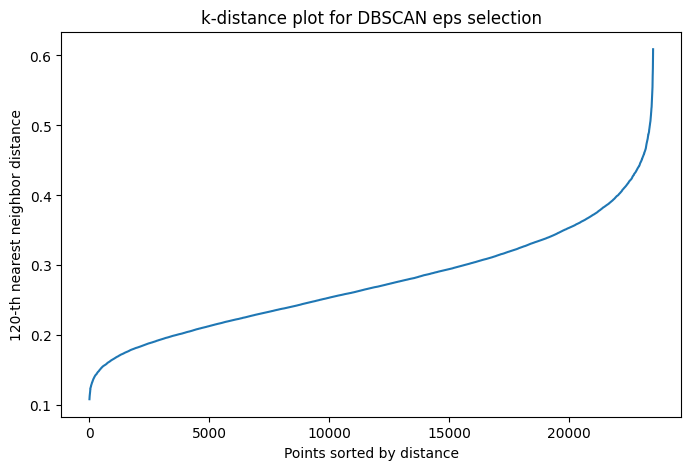

In [67]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

k = 120
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(pca_features)
distances, indices = neighbors_fit.kneighbors(pca_features)

# distance to kth nearest neighbor
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8,5))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-th nearest neighbor distance")
plt.title("k-distance plot for DBSCAN eps selection")
plt.show()


In [68]:
dbscan = DBSCAN(
    eps=0.4,
    min_samples=120
)

dbscan_labels = dbscan.fit_predict(pca_features)

df["dbscan_cluster"] = dbscan_labels



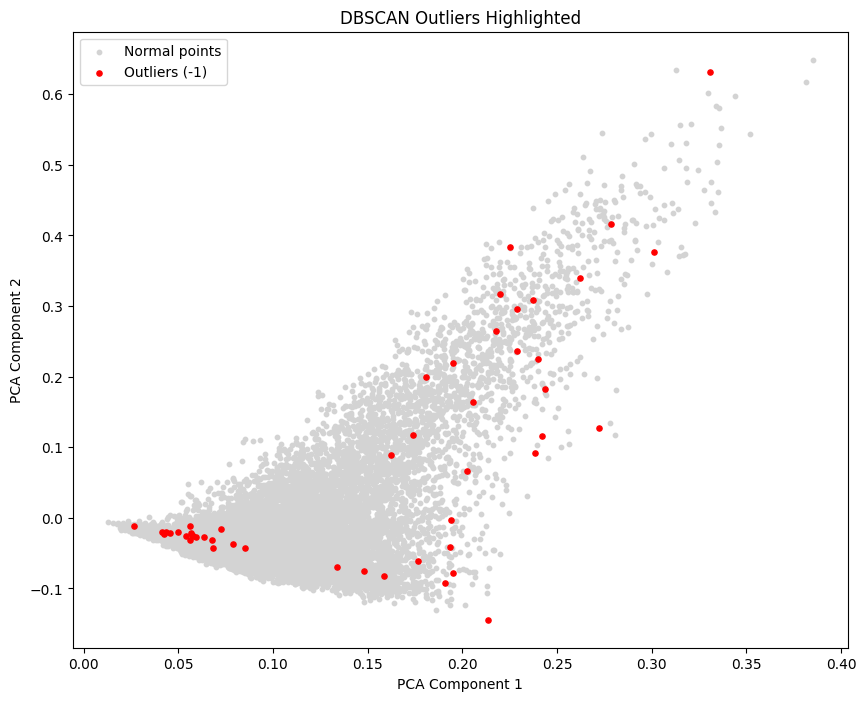

In [69]:
plt.figure(figsize=(10, 8))

# Mark non-outliers as one color (e.g., light gray)
non_outliers = dbscan_labels != -1
plt.scatter(
    pca_features[non_outliers, 0],
    pca_features[non_outliers, 1],
    c="lightgray",
    s=10,
    label="Normal points"
)

# Mark outliers as a strong color (e.g., red)
outliers = dbscan_labels == -1
plt.scatter(
    pca_features[outliers, 0],
    pca_features[outliers, 1],
    c="red",
    s=14,
    label="Outliers (-1)"
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Outliers Highlighted")
plt.legend()
plt.show()



In [70]:
outliers = df[df["dbscan_cluster"] == -1]
outliers["movie title"].head(10)


1699                 Exodus
3519    A Gnome Named Gnorm
5769                 HÃ¤jyt
6429            Hell Riders
6936       Phool Aur Angaar
7242      Kondaveeti Simham
7518                Matilda
8332                Newness
8365    Tell It to the Bees
9333              The Party
Name: movie title, dtype: object

In [71]:
# Identify outlier indices
outlier_indices = df[df["dbscan_cluster"] == -1].index

print("Removing", len(outlier_indices), "outliers")

# 1) Drop outliers from dataframe
df_clean = df.drop(index=outlier_indices).reset_index(drop=True)

# 2) Drop outliers from PCA matrix
pca_clean = np.delete(pca_features, outlier_indices, axis=0)

# 3) Drop outliers from TF-IDF matrix
tfidf_clean = tfidf_matrix[np.delete(np.arange(tfidf_matrix.shape[0]), outlier_indices)]


Removing 49 outliers


# GMM

In [72]:
from sklearn.mixture import GaussianMixture


In [73]:
bic_scores = []
aic_scores = []
k_range = range(1,21) 

for k in k_range:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42
    )
    gmm.fit(pca_features)
    bic_scores.append(gmm.bic(pca_features))
    aic_scores.append(gmm.aic(pca_features))


C:\Users\ecc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
C:\Users\ecc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


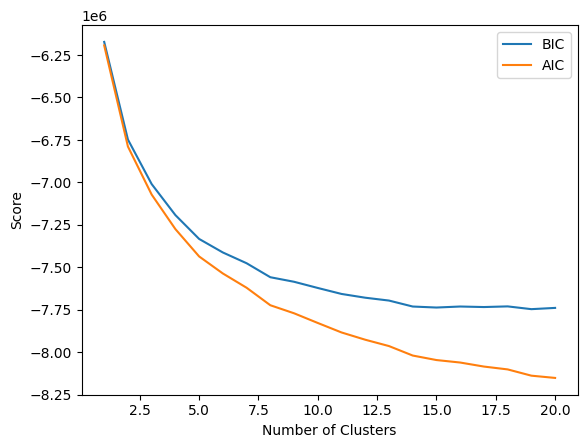

In [74]:
plt.plot(k_range, bic_scores, label="BIC")
plt.plot(k_range, aic_scores, label="AIC")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.show()


In [75]:
optimal_k = 10

gmm = GaussianMixture(
    n_components=optimal_k,
    covariance_type="full",
    random_state=42
)

gmm_labels = gmm.fit_predict(pca_features)


C:\Users\ecc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


In [76]:
df["gmm_cluster"] = gmm_labels
gmm_probs = gmm.predict_proba(pca_features)
for cluster_id in range(optimal_k):
    print(f"\nCluster {cluster_id}")
    sample_titles = df[df["gmm_cluster"] == cluster_id]["movie title"].head(20)
    print(sample_titles.tolist())




Cluster 0
['The Northman', 'Blade Runner 2049', 'The Hunger Games', 'Kingsman: The Secret Service', 'Apocalypto', 'Waterworld', 'Oldboy', 'The Crow', 'Kill Bill: Vol. 1', 'Zombieland', 'Sucker Punch', 'Conan the Barbarian', 'Hitman', 'Children of Men', 'Revenge', 'Hot Shots!', 'Law Abiding Citizen', 'Kate', 'Double Threat', 'Drive Angry']

Cluster 1
['Last Seen Alive', 'Spectre', 'Blade Runner', 'K.G.F: Chapter 2', 'Gladiator', '21 Bridges', 'John Wick', 'Terminator 2: Judgment Day', 'Speed', 'Ready or Not', 'Minority Report', 'El Camino: A Breaking Bad Movie', "Hitman's Wife's Bodyguard", 'The Fugitive', 'In Time', 'The Equalizer', 'V for Vendetta', "Don't Breathe 2", 'Greenland', 'Eraser']

Cluster 2
['Jurassic World Dominion', 'Black Adam', 'Fantastic Beasts: The Secrets of Dumbledore', 'Jurassic Park', 'Doctor Strange in the Multiverse of Madness', 'No Time to Die', 'Jurassic World', 'Jurassic World: Fallen Kingdom', 'The Lost City', 'Sonic the Hedgehog 2', 'Uncharted', 'The Lost 

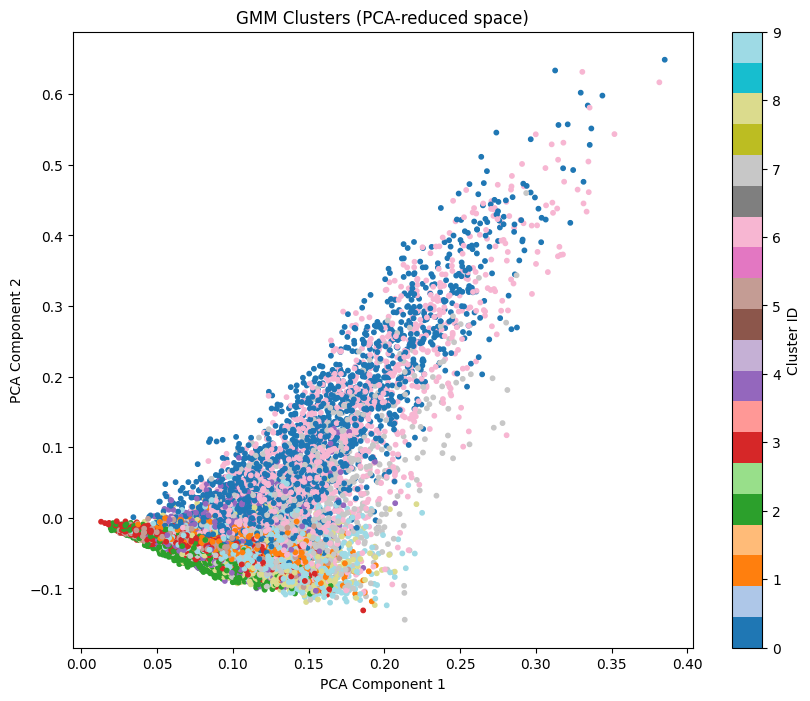

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(
    pca_features[:, 0],
    pca_features[:, 1],
    c=df["gmm_cluster"],
    cmap="tab20",
    s=10
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Clusters (PCA-reduced space)")
plt.colorbar(label="Cluster ID")
plt.show()


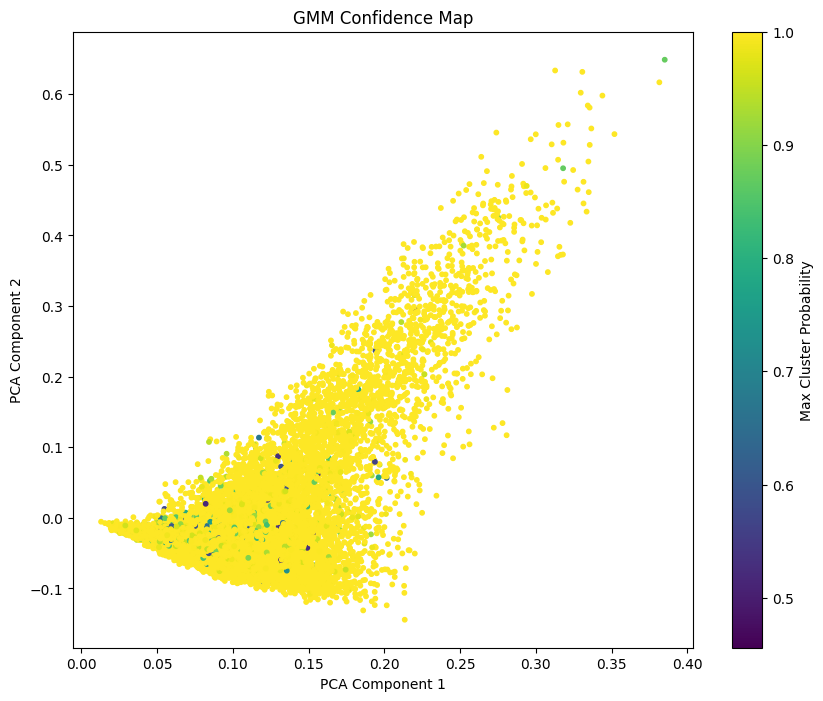

In [78]:
max_probs = gmm.predict_proba(pca_features).max(axis=1)

plt.figure(figsize=(10, 8))
plt.scatter(
    pca_features[:, 0],
    pca_features[:, 1],
    c=max_probs,
    cmap="viridis",
    s=10
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Confidence Map")
plt.colorbar(label="Max Cluster Probability")
plt.show()


# recommendation

In [84]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_movies(
    movie_title,
    df,
    tfidf_matrix,
    top_n=10
):
    # 1 — Find movie index safely
    matches = df.index[df["movie title"].str.lower() == movie_title.lower()]
    if len(matches) == 0:
        raise ValueError("Movie title not found in dataset.")
    
    idx = matches[0]

    # 2 — Check DBSCAN outlier label
    movie_dbscan_label = df.loc[idx, "dbscan_cluster"]

    if movie_dbscan_label == -1:
        # The movie itself is an outlier → no meaningful cluster
        # Fallback: compute similarity across NON-outliers only
        print("Note: Movie is an outlier in DBSCAN → using global similarity among non-outliers.")

        valid_indices = df.index[df["dbscan_cluster"] != -1].to_numpy()

        similarities = cosine_similarity(
            tfidf_matrix[idx],
            tfidf_matrix[valid_indices]
        ).flatten()

        top_positions = similarities.argsort()[::-1][1:top_n+1]
        top_indices = valid_indices[top_positions]

        return df.loc[top_indices, ["movie title", "Generes", "Top 5 Casts", "Director"]]

    # 3 — Otherwise proceed normally (GMM cluster-based)
    cluster_id = df.loc[idx, "gmm_cluster"]

    # Candidates = Same GMM cluster AND not DBSCAN outliers
    candidate_indices = df.index[
        (df["gmm_cluster"] == cluster_id) &
        (df["dbscan_cluster"] != -1)
    ].to_numpy()

    # 4 — Compute similarity
    similarities = cosine_similarity(
        tfidf_matrix[idx],
        tfidf_matrix[candidate_indices]
    ).flatten()

    # 5 — Rank top movies
    top_positions = similarities.argsort()[::-1][1:top_n+1]
    top_indices = candidate_indices[top_positions]

    return df.loc[top_indices, ["movie title", "Generes", "Top 5 Casts", "Director"]]


In [90]:
# call without passing the cluster array (the function uses df["gmm_cluster"] internally)
recommend_movies(
    "Spider-Man",
    df,
    tfidf_matrix,
    top_n=10
)


,movie title,Generes,Top 5 Casts,Director
77,The Amazing Spider-Man,"['Action', 'Adventure', 'Sci-Fi']","['Alvin Sargent', 'Steve Kloves', 'Andrew Garf...",Marc Webb
202,Spider-Man: Far from Home,"['Action', 'Adventure', 'Sci-Fi']","['Erik Sommers', 'Stan Lee', 'Tom Holland', 'S...",Jon Watts
108,Spider-Man: Homecoming,"['Action', 'Adventure', 'Sci-Fi']","['John Francis Daley', 'Jon Watts', 'Tom Holla...",Jon Watts
812,Superhero Movie,"['Action', 'Comedy', 'Sci-Fi']","['Drake Bell', 'Leslie Nielsen', 'Sara Paxton'...",Craig Mazin
19071,Branagh Theatre Live: Romeo and Juliet,['Romance'],"['Benjamin Caron', 'Arthur Brooke', 'William P...",Rob Ashford
5919,Zebraman,"['Action', 'Comedy', 'Sci-Fi']","['ShÃ´ Aikawa', 'KyÃ´ka Suzuki', 'Atsuro Watab...",Takashi Miike
1434,The Lego Ninjago Movie,"['Animation', 'Action', 'Adventure']","['Bob Logan', 'Bob Logan', 'Paul Fisher', 'Wil...",Charlie Bean
841,Star Wars: The Clone Wars,"['Animation', 'Action', 'Adventure']","['Steven Melching', 'Scott Murphy', 'Matt Lant...",Dave Filoni
16867,Bugs Bunny's 3rd Movie: 1001 Rabbit Tales,"['Animation', 'Adventure', 'Comedy']","['Robert McKimson', 'John W. Dunn', 'David Det...",Friz Freleng
13860,Cradle Will Rock,['Drama'],"['Hank Azaria', 'RubÃ©n Blades', 'Joan Cusack'...",Tim Robbins


In [94]:
recommend_movies(
    "Interstellar",
    df,
    tfidf_matrix,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
7627,The Prestige,"['Drama', 'Mystery', 'Sci-Fi']","['Christopher Nolan', 'Christopher Priest', 'C...",Christopher Nolan
16551,Patagonia,"['Adventure', 'Drama']","['Marc Evans', 'Matthew Rhys', 'Marta Lubos', ...",Marc Evans
2810,Ink,"['Action', 'Drama', 'Fantasy']","['Christopher Soren Kelly', 'Quinn Hunchar', '...",Jamin Winans
18570,Anti Matter,"['Horror', 'Mystery', 'Sci-Fi']","['Yaiza Figueroa', 'Philippa Carson', 'Tom Bar...",Keir Burrows
10980,These Final Hours,"['Drama', 'Sci-Fi', 'Thriller']","['Jessica De Gouw', 'Nathan Phillips', 'David ...",Zak Hilditch
7887,Ad Astra,"['Adventure', 'Drama', 'Mystery']","['Ethan Gross', 'Brad Pitt', 'Tommy Lee Jones'...",James Gray
16783,Charlie's Ghost Story,"['Adventure', 'Comedy', 'Fantasy']","['Clint Hutchison', 'Mark Twain', 'Trenton Kni...",Anthony Edwards
20251,Memento,"['Mystery', 'Thriller']","['Jonathan Nolan', 'Guy Pearce', 'Carrie-Anne ...",Christopher Nolan
15792,Alien from L.A.,"['Adventure', 'Comedy', 'Sci-Fi']","['Sandra Berg', 'Albert Pyun', 'Kathy Ireland'...",Albert Pyun
7737,After Yang,"['Drama', 'Sci-Fi']","['Kogonada', 'Colin Farrell', 'Jodie Turner-Sm...",Kogonada


In [95]:
recommend_movies(
    "The Batman",
    df,
    tfidf_matrix,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
3093,Batman and Robin,"['Action', 'Adventure', 'Family']","['George H. Plympton', 'Joseph F. Poland', 'Ro...",Spencer Gordon Bennet
2241,Batman: Gotham by Gaslight,"['Animation', 'Action', 'Adventure']","['Brian Augustyn', 'Mike Mignola', 'Bruce Gree...",Sam Liu
1646,Batman: Mask of the Phantasm,"['Animation', 'Action', 'Adventure']","['Frank Paur', 'Alan Burnett', 'Paul Dini', 'M...",Kevin Altieri
641,The Lego Batman Movie,"['Animation', 'Action', 'Adventure']","['Chris McKenna', 'Erik Sommers', 'Will Arnett...",Chris McKay
1704,"Batman: The Long Halloween, Part Two","['Animation', 'Action', 'Crime']","['Tim Sale', 'Tim Sheridan', 'Jensen Ackles', ...",Chris Palmer
1304,"Batman: The Long Halloween, Part One","['Animation', 'Action', 'Crime']","['Tim Sale', 'Tim Sheridan', 'Jensen Ackles', ...",Chris Palmer
889,Injustice,"['Animation', 'Action', 'Adventure']","['Tom Taylor', 'Justin Hartley', 'Anson Mount'...",Matt Peters
1833,Gotham City Sirens,"['Action', 'Adventure', 'Comedy']","['Bruce Timm', 'Margot Robbie', 'Paul Dini', '...",Paul Dini
342,Batman v Superman: Dawn of Justice,"['Action', 'Adventure', 'Sci-Fi']","['David S. Goyer', 'Bob Kane', 'Ben Affleck', ...",Zack Snyder
23426,Joker Rising,['Crime'],"['Manuel Eduardo Ramirez', 'Dylan Hobbs', 'Kat...",Alek Gearhart


In [97]:
recommend_movies(
    "Bad Boys",
    df,
    tfidf_matrix,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
704,Bad Boys II,"['Action', 'Comedy', 'Crime']","['Marianne Wibberley', 'Cormac Wibberley', 'Wi...",Michael Bay
1690,Hollywood Homicide,"['Action', 'Comedy', 'Crime']","['Ron Shelton', 'Harrison Ford', 'Josh Hartnet...",Ron Shelton
486,Bad Boys for Life,"['Action', 'Comedy', 'Crime']","['Peter Craig', 'Joe Carnahan', 'Chris Bremner...",Adil El Arbi
11471,Pride and Glory,"['Crime', 'Drama', 'Thriller']","[""Gavin O'Connor"", ""Greg O'Connor"", 'Edward No...",Gavin O'Connor
11829,Lonely Hearts,"['Biography', 'Crime', 'Drama']","['John Travolta', 'Salma Hayek', 'Jared Leto',...",Todd Robinson
13031,Killer Looks,['Crime'],"['Katherine Flannery', 'Vaughn Green', 'Jeffre...",Christopher Krueger
13790,Appointment with Danger,"['Crime', 'Drama', 'Film-Noir']","['Warren Duff', 'Alan Ladd', 'Phyllis Calvert'...",Lewis Allen
11788,The Naked City,"['Crime', 'Drama', 'Film-Noir']","['Malvin Wald', 'Barry Fitzgerald', 'Howard Du...",Jules Dassin
3847,Miami Supercops,"['Action', 'Comedy', 'Crime']","['Luciano Vincenzoni', 'Terence Hill', 'Bud Sp...",Bruno Corbucci
9908,Did You Hear About the Morgans?,"['Comedy', 'Drama', 'Romance']","['Hugh Grant', 'Sarah Jessica Parker', 'Sam El...",Marc Lawrence


In [99]:
recommend_movies(
    "Ice Age",
    df,
    tfidf_matrix,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
15464,Ice Age: Collision Course,"['Animation', 'Adventure', 'Comedy']","['Michael J. Wilson', 'Michael Berg', 'Yoni Br...",Michael Thurmeier
15546,Ice Age: The Meltdown,"['Animation', 'Adventure', 'Comedy']","['Gerry Swallow', 'Jim Hecht', 'Ray Romano', '...",Carlos Saldanha
1126,Alpha,"['Action', 'Adventure', 'Drama']","['Albert Hughes', 'Kodi Smit-McPhee', 'JÃ³hann...",Albert Hughes
15766,Prehysteria!,"['Adventure', 'Comedy', 'Family']","['Pete von Sholly', 'Greg Suddeth', 'Mark Gold...",Albert Band
15936,Master of the World,['Adventure'],"['Sven Kruger', ""Sasha D'Arc"", 'Viviana Maria ...",Alberto Cavallone
15544,One Million Years B.C.,"['Adventure', 'Fantasy']","['Mickell Novack', 'George Baker', 'Raquel Wel...",Don Chaffey
15658,Early Man,"['Animation', 'Adventure', 'Comedy']","['James Higginson', 'Nick Park', 'Eddie Redmay...",Nick Park
2014,Sinbad and the Eye of the Tiger,"['Action', 'Adventure', 'Family']","['Ray Harryhausen', 'Patrick Wayne', 'Jane Sey...",Sam Wanamaker
16046,High in the Clouds,"['Animation', 'Adventure', 'Comedy']","['Jon Croker', 'Geoff Dunbar', 'Timothy Reckar...",Timothy Reckart
16015,Dinosaurus!,"['Adventure', 'Comedy', 'Fantasy']","['Dan E. Weisburd', 'Jean Yeaworth', 'Ward Ram...",Irvin S. Yeaworth Jr.


In [101]:
recommend_movies(
    "se7en",
    df,
    tfidf_matrix,
    top_n=10
)

,movie title,Generes,Top 5 Casts,Director
694,Fallen,"['Action', 'Crime', 'Drama']","['Denzel Washington', 'John Goodman', 'Donald ...",Gregory Hoblit
23352,Evil Judgment,"['Crime', 'Mystery', 'Thriller']","['Claudio Castravelli', 'Pamela Collyer', 'Jac...",Claudio Castravelli
3585,Grandmaster,"['Action', 'Thriller']","['Mohanlal', 'Priyamani', 'Babu Antony', 'B. U...",B. Unnikrishnan
21443,Bundy and the Green River Killer,"['Crime', 'Drama', 'Thriller']","['Mark Homer', 'Lara Goodison', 'Richard Mark'...",Andrew Jones
21395,Killer Among Us,"['Horror', 'Thriller']","['Daniel Lichtenberg', 'Yasha Jackson', 'Andre...",Charlie Scharfman
9464,The Pledge,"['Crime', 'Drama', 'Mystery']","['Jerzy Kromolowski', 'Mary Olson-Kromolowski'...",Sean Penn
13255,The Prophet's Game,"['Crime', 'Drama', 'Thriller']","['Dennis Hopper', 'Stephanie Zimbalist', 'Robe...",David Worth
22026,100 Days to Live,"['Crime', 'Thriller']","['Colin Egglesfield', 'Gideon Emery', 'Heidi J...",Ravin Gandhi
1493,Split Second,"['Action', 'Crime', 'Horror']","['Rutger Hauer', 'Kim Cattrall', 'Alastair Dun...",Tony Maylam
13513,Faking a Murderer,"['Comedy', 'Crime', 'Horror']","['Stuart Stone', 'Adam Rodness', 'Stuart Stone...",Stuart Stone
